In [29]:
%env KERAS_BACKEND=tensorflow
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, FloatSlider
# Keras functions
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, concatenate
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD, Adam
from keras import metrics

# Keras dataset
from keras.datasets import mnist

# Keras utilis function
from keras.utils import np_utils

from keras import backend as K

env: KERAS_BACKEND=tensorflow


In [30]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

In [31]:
x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)

x_train -= x_train.min()
x_train = x_train/x_train.max()

# Autoencoder(把自己壓縮再回復)

In [32]:
x = Input(shape=(784,))

enc_1 = Dense(100, activation='sigmoid')
enc_2 = Dense(2, activation='sigmoid') # 從784維變成2維即可以畫圖

h = enc_2(enc_1(x))

dec_1 = Dense(100, activation='sigmoid')
dec_2 = Dense(784, activation='sigmoid')

x_hat = dec_2(dec_1(h))

In [33]:
autoencoder = Model(x, x_hat)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 202       
_________________________________________________________________
dense_7 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_8 (Dense)              (None, 784)               79184     
Total params: 158,186
Trainable params: 158,186
Non-trainable params: 0
_________________________________________________________________


In [34]:
autoencoder.compile(loss='mse', optimizer=Adam())

In [35]:
# autoencoder.fit(x_train, x_train, batch_size=1024, epochs=100)
autoencoder.load_weights('autoencoder_handwriting_model_weights.h5')

## 分拆兩個子模型(Encoder, Decoder)

In [36]:
Encoder = Model(x, h)
Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [37]:
h_input = Input(shape=(2,))
Decoder = Model(h_input, dec_2(dec_1(h_input)))
Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_8 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


## 視覺化Encoder(展示資料的latent presentation)

In [38]:
idx = 5998
Encoder.predict(x_train[idx: idx + 1]) # 要是一筆784維的向量，不能是784維的向量

array([[0.2447453 , 0.11025776]], dtype=float32)

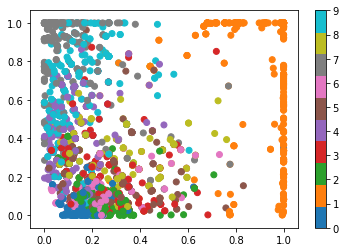

In [39]:
idxs = np.random.randint(0, 10000, 3000)
latents = Encoder.predict(x_test[idxs])
plt.scatter(latents[:, 0], latents[:, 1], c=y_test0[idxs], cmap="tab10")
plt.colorbar(); # 圖例，不同的數字用不同顏色

從圖可以看出用這個二維的平面能不能很好的區分每一種數字，如果區分明確，就是好的降維。

## 視覺化Decoder

(-0.5, 419.5, 419.5, -0.5)

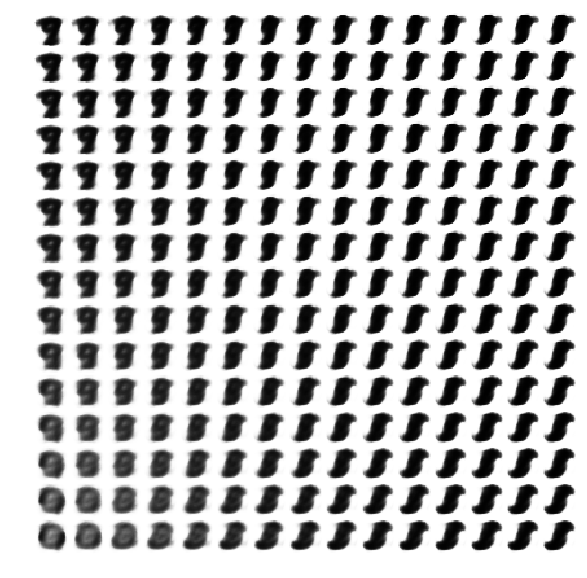

In [40]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[(n-i-1) * digit_size: (n - i) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys')
plt.axis('off');

把剛剛sigmoid出來0~1的結果分成xy各15個區塊，將那些區塊中取中間值後還源的圖片疊加。

# Variational Autoencoder
在此， Encoder 的作用不是將資料表示成 latent，而是將資料表示成常態分配的兩個參數，平均數與變異數，透過在分布中隨機抽取的方式將x, h串接。<br>
每個位置間是獨立的多元常態分派。<br>
在還原時，並不是拿原本的點來還原，而是用一個常態分配的平均與變異數，抽樣後再還原。<br>
把Autoencoder中間接一個sampling，Encoder變兩倍大，會出現一個新的loss function，在標準常態那邊，因為要使出來的結果愈接近常態分配愈好。

In [42]:
enc_1 = Dense(100, activation='sigmoid')
# enc_2 = Dense(2, activation='sigmoid') 原本的這個拆成下面兩層了(mean, variance)

enc_mean = Dense(2)
enc_log_var = Dense(2) # 取log，讓變異數不要恆正

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

Encoder層

In [43]:
x = Input(shape=(784,))

enc_x = enc_1(x)
z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

抽樣層

In [45]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [46]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

Decoder層

In [47]:
dec_x = dec_2(z)
x_hat = dec_1(dec_x)

In [48]:
VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 100)          78500       input_5[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 2)            202         dense_9[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 2)            202         dense_9[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

## 自定義loss function

會有兩個loss functions，一個是神經網路本身輸入輸出要愈像愈好，另一個是中間的那個要盡量接近常態分配。

建立loss function

In [49]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

訓練 VAE

In [51]:
VAE.compile(loss=vae_loss, optimizer=Adam())
VAE.load_weights('VAE_handwriting_model_weights.h5') # 讀取權重

## VAE視覺化(分出Encoder, Decoder)

In [53]:
VAE_Encoder = Model(x, z_mean) # var的那個分支沒有用到
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))
VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_13 (Dense)             (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


## 視覺化VAE_Eecoder

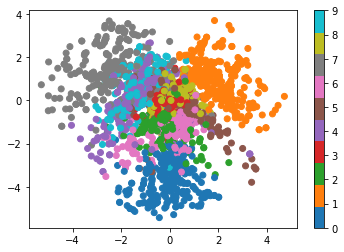

In [54]:
VAE_latents = VAE_Encoder.predict(x_test[idxs])
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test0[idxs], cmap="tab10")
plt.colorbar();

## 視覺化VAE_Decoder

In [55]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [56]:
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

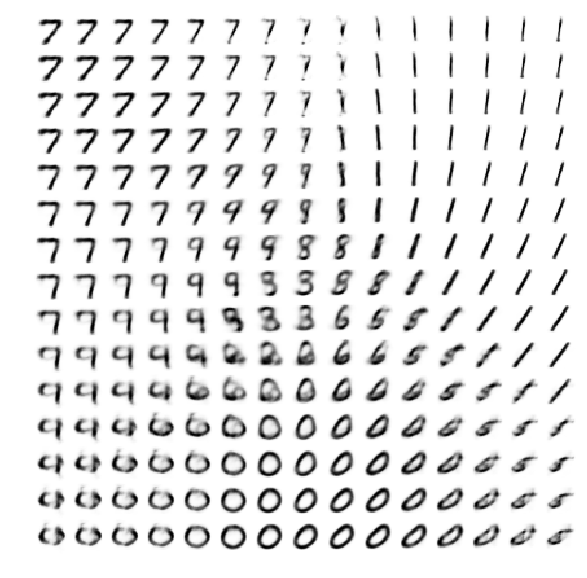

In [57]:
plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off');

VAE的結果相較於Autoencoder，其分類後點周遭的長相不會差太多。

## 動態比較VAE視覺化

In [86]:
def inBetween(a, b, t):
    idx_1, idx_2 = 0, 0
    while y_test0[idx_1] != a or y_test0[idx_2] != b:
        idx_1, idx_2 = np.random.randint(x_test.shape[0], size=2)
        
    data_0 = x_test0[idx_1]
    data_1 = x_test0[idx_2]
    data_t = (1-t)*x_test0[idx_1] + t*x_test0[idx_2]

    mu_0 = VAE_Encoder.predict(x_test[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_test[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')

In [87]:
n=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
interact(inBetween, a=n, b=n, t=FloatSlider(value=0.5, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,))

interactive(children=(Dropdown(description='a', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Dropdown(description='b', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), FloatSlider(value=0.5, description='t', max=1.0, step=0.02), Output()), _dom_classes=('widget-interact',))

<function __main__.inBetween>

In [ ]:
%matplotlib widget